# Loading Data

### The core idea of A/B testing is to see if changing something (e.g., button color, wording, etc.) leads to a higher conversion rate.

### A/B Testing is a method to compare two versions of a product (or a website, app feature, etc.) to determine which one performs better, based on specific metrics like conversion rates.

#### The goal of A/B testing is to make data-driven decisions by testing small changes before making them permanent. It helps optimize websites, apps, and campaigns to improve user engagement, sales, or other key business metrics.

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# Generate mock A/B test data

np.random.seed(42)
num_users_per_group = 5000
start_date = datetime(2023,11,1)
test_duration_days = 14



# Group A (also known as the Control Group (A))
control_users_id = [f'UserA_{10000+i}' for i in range(num_users_per_group)]
control_group_assignment = ['Control'] * num_users_per_group # This just labels all 5,000 users as belonging to the "Control" group

control_conversions = np.random.binomial(1, 0.10, num_users_per_group)
# We assume that 10% of users in the control group convert (take an action, like signing up or buying something). 
# This is modeled using a binomial distribution (np.random.binomial(1, 0.10)). 
# Each user has a 10% chance of converting, and the result is either 1 (converted) or 0 (not converted).

control_clicks = np.random.randint(0, 15, num_users_per_group)
# This is a random number between 0 and 14, representing how many clicks each user made on the website

control_page_views = control_clicks + np.random.randint(1,5,num_users_per_group)
# Each user has at least as many page views as clicks, but a random number between 1 and 5 is added to simulate more pages being viewed than clicked.

control_page_views = np.maximum(1, control_page_views) # ensures there’s always at least 1 page view




# Group B (Also known as the Treatment Group (B))

treatment_user_ids = [f'UserB_{20000+i}' for i in range(num_users_per_group)]
treatment_group_assignment = ['Treatment'] * num_users_per_group

treatment_conversions = np.random.binomial(1, 0.115, num_users_per_group)
# Assume a target conversion rate of 11.5% for treatment (1.5% lift)

treatment_clicks = np.random.randint(0,17,num_users_per_group) # slightly more clicks then the control group

treatment_page_views = treatment_clicks + np.random.randint(1,5,num_users_per_group)
treatment_page_views = np.maximum(1,treatment_page_views)




# Combine Data
all_user_ids = control_users_id + treatment_user_ids
all_groups = control_group_assignment + treatment_group_assignment
all_conversions = np.concatenate([control_conversions, treatment_conversions])
all_clicks = np.concatenate([control_clicks, treatment_clicks])
all_views = np.concatenate([control_page_views, treatment_page_views])


# This line of code uses a list comprehension to efficiently generate a list of 10,000 randomized dates for the A/B test
# calculates a random day within the 14-day test period for each user
# Here, we generate a random date for each user within the 14-day test period.
# The start_date is November 1, 2023, and timedelta(days=np.random.randint(0, test_duration_days)) adds a random number of days (between 0 and 13) to that date.

all_dates = [(start_date + timedelta(days = np.random.randint(0,test_duration_days))).strftime('%Y-%m-%d') for _ in range(num_users_per_group*2)]


df_ab_test = pd.DataFrame(

    {
        'UserID': all_user_ids,
        'Group': all_groups,
        'Date': all_dates,
        'Clicks': all_clicks,
        'PageViews': all_views,
        'Converted':all_conversions
    }
)


df_ab_test['Clicks'] = df_ab_test.apply(lambda row: min(row['Clicks'], row['PageViews']), axis = 1)
# A data cleaning and consistency check
# This line ensures that the number of clicks a user has can't be higher than the number of page views.
# axis = 1 This crucial argument tells pandas to apply the function across the rows (horizontally), giving the function access to both 'Clicks' and 'PageViews' for a single user.


df_ab_test.to_csv('ab_test_results_mock_data.csv', index = False)
print(df_ab_test.sample(10, random_state=42))
df_ab_test.head()


           UserID      Group        Date  Clicks  PageViews  Converted
6252  UserB_21252  Treatment  2023-11-07       4          8          0
4684  UserA_14684    Control  2023-11-10       1          5          0
1731  UserA_11731    Control  2023-11-04       6          8          0
4742  UserA_14742    Control  2023-11-12       2          3          0
4521  UserA_14521    Control  2023-11-12       8         12          0
6340  UserB_21340  Treatment  2023-11-03       3          7          0
576   UserA_10576    Control  2023-11-08       0          4          0
5202  UserB_20202  Treatment  2023-11-05      14         15          1
6363  UserB_21363  Treatment  2023-11-12      14         16          1
439   UserA_10439    Control  2023-11-08       8          9          0


,UserID,Group,Date,Clicks,PageViews,Converted
0,UserA_10000,Control,2023-11-08,2,5,0
1,UserA_10001,Control,2023-11-14,7,8,1
2,UserA_10002,Control,2023-11-03,6,7,0
3,UserA_10003,Control,2023-11-06,2,6,0
4,UserA_10004,Control,2023-11-03,5,6,0


# 2 - Data Loading & Cleaning

In [2]:
import pandas as pd
import numpy as np

csv = "ab_test_results_mock_data.csv"
df = pd.read_csv(csv)

# Correcting the mistake of 'Data' Column
if 'Data' in df.columns and 'Date' not in df.columns:
    df = df.rename(columns = {'Data':'Date'})

df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')

print("No of Rows, Columns of the file ab_test_results_mock_data.csv : ", df.shape)
print()
print("Columns of the file ab_test_results_mock_data.csv", df.columns.tolist())
print()
print("Missing Values per column: ")
print(df.isna().sum())
print()

# Check Clicks <= PageViews
violations = df[df['Clicks'] >  df['PageViews']]

print("Number of Rows where Clicks > PageViews is: ", len(violations))



# Check Group Assignment Counts
group_counts = df['Group'].value_counts(dropna=False)
print("\nGroup Counts: ")
print(group_counts)
print()

# Check Converted Counts
conv_counts = df['Converted'].value_counts(dropna=False)
print("\nConverted Counts: ")
print(conv_counts)
print()


# Check conversion rates reported in Excel match programmatically
print("\n Conversion Summary by Group: ")
conv_by_group = df.groupby('Group')['Converted'].agg(['sum', 'count', 'mean']).rename(columns = {'mean':'conv_rate'})
conv_by_group['conv_pct'] = conv_by_group['conv_rate'] * 100
print(conv_by_group)


# Check for users in both groups or duplicated UserIDs

unique_user_count = df['UserID'].nunique()
total_rows = len(df)
print()
print("The number of unique customers (unique UserIDs) in my data is:", unique_user_count, " and the the total no of rows in my data is:", total_rows)
print()

# Check for duplicates
dups = df[df.duplicated(subset = ['UserID'], keep = False)].sort_values('UserID')
# df.duplicated is a DataFrame method that returns a Boolean Series, where True indicates a row is a duplicate, and False indicates it is not.
# create a new DataFrame, dups, that contains all the rows from the original DataFrame df where the UserID value appears more than once
print("Number of Duplicated UserID rows is", len(dups))
print()


# Check if any userID appears under both groups
userID_group_counts = df.groupby('UserID')['Group'].nunique() # Every unique user gets their own group.
# .nunique(): This is the key function. 
# For each UserID group, it calculates the number of unique group assignments they received.

users_in_both = userID_group_counts[userID_group_counts > 1]
print("No of users present in both groups (should be 0): ", len(users_in_both))
print()


# Distribution Checks for Engagement Metrics

print("Engagement Metrics by Group")

engagement = df.groupby('Group').agg(
    users = ('UserID', 'count'),
    avg_clicks = ('Clicks', 'mean'),
    std_clicks = ('Clicks', 'std'),
    avg_page_views = ('PageViews', 'mean'),
    std_page_views = ('PageViews', 'std'),
    total_clicks = ('Clicks', 'sum'),
    total_pageviews = ('PageViews', 'sum')
)

engagement['clicks_per_pageview'] = engagement['total_clicks'] / engagement['total_pageviews']

print(engagement)


print("\n Date Counts (overall): ")
print(df['Date'].value_counts().sort_index().head(15))

print()

print("\n Date counts by group (top 10 dates): ")
print(df.groupby(['Date', 'Group']).size().unstack(fill_value=0).sort_index().head(15))
print()

print("\nQuick randomization check (difference in mean clicks & pageviews between groups):")

# The purpose is to see if the random assignment of users to groups was successful.
# If the difference in these means is very large, it suggests the groups were imbalanced to begin with, which could bias the final test results.

diff_clicks = engagement.loc['Treatment','avg_clicks'] - engagement.loc['Control','avg_clicks']
diff_pageviews = engagement.loc['Treatment','avg_page_views'] - engagement.loc['Control','avg_page_views']
print(f"Mean clicks diff (Treatment - Control): {diff_clicks:.4f}")
print(f"Mean pageviews diff (Treatment - Control): {diff_pageviews:.4f}")



No of Rows, Columns of the file ab_test_results_mock_data.csv :  (10000, 6)

Columns of the file ab_test_results_mock_data.csv ['UserID', 'Group', 'Date', 'Clicks', 'PageViews', 'Converted']

Missing Values per column: 
UserID       0
Group        0
Date         0
Clicks       0
PageViews    0
Converted    0
dtype: int64

Number of Rows where Clicks > PageViews is:  0

Group Counts: 
Group
Control      5000
Treatment    5000
Name: count, dtype: int64


Converted Counts: 
Converted
0    8931
1    1069
Name: count, dtype: int64


 Conversion Summary by Group: 
           sum  count  conv_rate  conv_pct
Group                                     
Control    479   5000     0.0958      9.58
Treatment  590   5000     0.1180     11.80

The number of unique customers (unique UserIDs) in my data is: 10000  and the the total no of rows in my data is: 10000

Number of Duplicated UserID rows is 0

No of users present in both groups (should be 0):  0

Engagement Metrics by Group
           users  av

# Primary Metric Calculation (Conversion) and the Z-Test

##### Control group has 479 conversions (users who completed a desired action, like a purchase or sign-up) out of 5000 total users, resulting in a conversion rate of 9.58%.

##### Treatment group has 590 conversions out of 5000 users, resulting in a conversion rate of 11.80%.

##### Now, the important thing here is: Does this difference in conversion rate (from 9.58% to 11.80%) reflect a real effect of the new feature, or could it just be random noise?

###### To answer this question, we need to use statistical tests to check if the difference between these two groups is statistically significant (meaning that it's not likely to have happened by random chance).

###### Null Hypothesis (H₀): There is no difference between the Control and Treatment groups. Any observed difference is due to random chance.
###### Alternative Hypothesis (H₁): The Treatment group has a higher conversion rate than the Control group (because we're hoping the new feature improves conversions).

In [64]:
pip install statsmodels


  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/df/4c/2feda3a9f0e17444a84ba5398ada6a4d2e1b8f832760048f04e2b8ea0c41/statsmodels-0.14.5-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for scipy!=1.9.2,>=1.8 from https://files.pythonhosted.org/packages/34/95/20e02ca66fb495a95fba0642fd48e0c390d0ece9b9b14c6e931a60a12dea/scipy-1.16.2-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.8 kB 145.2 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 196.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 196.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 196.9 kB/s eta 0:00:01
     ---------------------

In [1]:
import statsmodels
print("Statsmodels Version: ", statsmodels.__version__)

Statsmodels Version:  0.14.4


In [3]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

summary = df.groupby('Group')['Converted'].agg(['sum', 'count']).rename(columns = {'sum':'conversions', 'count':'n'})
summary['conv_rate'] = (summary['conversions'] / summary['n']) * 100
print(summary)

#Z-Test

count = summary['conversions'].values   
nobs = summary['n'].values

stat, pval_two_sided = proportions_ztest(count, nobs, alternative='two-sided')
stat_one_sided, pval_one_sided = proportions_ztest(count, nobs, alternative='larger')

# The Z-statistic is a measure of how far apart the two conversion rates (9.58% and 11.80%) are, in terms of standard deviation units.

print("\n Z-Test Results")
print(f"Z-Statistic: {stat:.4f}, two-sided p-value: {pval_two_sided: .6f}")
print(f"Z-Statistic: {stat_one_sided: .4f}, one-sided p-value (treatment > Control): {pval_one_sided: .6f}")
print()
"""
Note: The sign (-3.59) just indicates the order of subtraction.
Since the code puts Control first and Treatment second, a negative Z-score means the Treatment rate (11.80%) is higher than the Control rate (9.58%).
"""

"""
p = 0.000328 means there's a 0.0328% chance that the difference is just random.
Since this is very small, we can confidently reject the null hypothesis and say the new feature is likely improving conversions.
"""

"""
Given that your p-value is very small (0.000328), we can reject the null hypothesis and conclude that there is a statistically significant difference between the two groups.
However, the one-sided p-value being high suggests that the treatment didn’t actually perform better than control 
— it might even have been slightly worse.
"""

p1 = summary.loc['Control','conv_rate']
p2 = summary.loc['Treatment','conv_rate']
diff = p2 - p1
print("Control Group Conversion Rate (p1):", p1, "%")
print("Treatment Group Conversion Rate (p2):", p2, "%")
print("Control Group Users (n):", summary.loc['Control', 'n'])
print("Treatment Group Users (n):", summary.loc['Treatment', 'n'])
print("The Difference between p1 and p2 is:", diff, "%")
print()

# Debugging to ensure no division by zero or invalid calculations
print("Control Variance (p1 * (1 - p1)):", p1 * (1 - p1))
print("Treatment Variance (p2 * (1 - p2)):", p2 * (1 - p2))

conf_interval = confint_proportions_2indep(count[0], nobs[0], count[1], nobs[1], alpha=0.05)

print(f"95% Confidence Interval for the difference: {conf_interval}")

# Calculate standard error
# se = np.sqrt(p1 * (1 - p1) / summary.loc['Control', 'n'] + p2 * (1 - p2) / summary.loc['Treatment', 'n'])

# print(f"Calculated Standard Error: {se}")



# se = np.sqrt(p1*(1-p1)/summary.loc['Control','n'] + p2*(1-p2)/summary.loc['Treatment','n'])
# print("The Value of Standard Error is: ", se)
# z_975 = 1.959963984540054  # 97.5 percentile
# ci_low = diff - z_975*se
# ci_high = diff + z_975*se
# print(f"\nObserved absolute difference (Treatment - Control): {diff:.4f} ({diff*100:.2f} percentage points)")
# print(f"95% CI for difference: [{ci_low:.4f}, {ci_high:.4f}]")


           conversions     n  conv_rate
Group                                  
Control            479  5000       9.58
Treatment          590  5000      11.80

 Z-Test Results
Z-Statistic: -3.5924, two-sided p-value:  0.000328
Z-Statistic: -3.5924, one-sided p-value (treatment > Control):  0.999836

Control Group Conversion Rate (p1): 9.58 %
Treatment Group Conversion Rate (p2): 11.799999999999999 %
Control Group Users (n): 5000
Treatment Group Users (n): 5000
The Difference between p1 and p2 is: 2.219999999999999 %

Control Variance (p1 * (1 - p1)): -82.1964
Treatment Variance (p2 * (1 - p2)): -127.43999999999997
95% Confidence Interval for the difference: (-0.034322089182628496, -0.010092848169190713)


In [ ]:
# Manually calcualting the statistical values

import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# replace these with your computed numbers if you re-run
conv_control = 479
n_control = 5000
conv_treatment = 590
n_treatment = 5000

count = np.array([conv_control, conv_treatment])
nobs  = np.array([n_control, n_treatment])

stat_two, pval_two = proportions_ztest(count, nobs, alternative='two-sided')
stat_one, pval_one = proportions_ztest(count, nobs, alternative='larger')

p1 = conv_control / n_control
p2 = conv_treatment / n_treatment
diff = p2 - p1
se = np.sqrt(p1*(1-p1)/n_control + p2*(1-p2)/n_treatment) # SE: Standard Error: This is the measure of the variability or uncertainty around the difference in conversion rates. A smaller SE means more confidence in the estimate.
z = diff / se
ci_low = diff - 1.96 * se
ci_high = diff + 1.96 * se

print("p1, p2:", p1, p2)
print("Absolute diff:", diff)
print("Z (manual):", z)
print("One-sided p:", pval_one)
print("Two-sided p:", pval_two)
print("95% CI:", (ci_low, ci_high))


p1, p2: 0.0958 0.118
Absolute diff: 0.022199999999999998
Z (manual): 3.594715278594033
One-sided p: 0.9998361736450229
Two-sided p: 0.000327652709954209
95% CI: (0.010095564285965246, 0.03430443571403475)


In [16]:
pip install matplotlib

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/31/3c/80816f027b3a4a28cd2a0a6ef7f89a2db22310e945cd886ec25bfb399221/matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/19/e8/6026ed58a64563186a9ee3f29f41261fd1828f527dd93d33b60feca63352/contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/88/8f/a55b5550cd33cd1028601df41acd057d4be20efa5c958f417b0c0613924d/fonttools-4.60.1-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/114.6 kB ? eta -:--:--
     --- ------------------------------------ 10.2/114.6 kB ? eta -

In [5]:
daily = df.groupby([df['Date'].dt.date, 'Group'])['Converted'].agg(['sum','count']).reset_index()
print(daily)

          Date      Group  sum  count
0   2023-11-01    Control   31    326
1   2023-11-01  Treatment   41    328
2   2023-11-02    Control   37    313
3   2023-11-02  Treatment   41    356
4   2023-11-03    Control   29    385
5   2023-11-03  Treatment   37    353
6   2023-11-04    Control   25    310
7   2023-11-04  Treatment   43    351
8   2023-11-05    Control   39    397
9   2023-11-05  Treatment   34    366
10  2023-11-06    Control   34    362
11  2023-11-06  Treatment   40    378
12  2023-11-07    Control   32    338
13  2023-11-07  Treatment   54    379
14  2023-11-08    Control   40    361
15  2023-11-08  Treatment   40    340
16  2023-11-09    Control   24    364
17  2023-11-09  Treatment   42    350
18  2023-11-10    Control   40    399
19  2023-11-10  Treatment   45    345
20  2023-11-11    Control   36    367
21  2023-11-11  Treatment   41    376
22  2023-11-12    Control   36    366
23  2023-11-12  Treatment   48    344
24  2023-11-13    Control   41    380
25  2023-11-

### Daily conversion stability (see if uplift is consistent over days):

          Date      Group  sum  count
0   2023-11-01    Control   31    326
1   2023-11-01  Treatment   41    328
2   2023-11-02    Control   37    313
3   2023-11-02  Treatment   41    356
4   2023-11-03    Control   29    385
5   2023-11-03  Treatment   37    353
6   2023-11-04    Control   25    310
7   2023-11-04  Treatment   43    351
8   2023-11-05    Control   39    397
9   2023-11-05  Treatment   34    366
10  2023-11-06    Control   34    362
11  2023-11-06  Treatment   40    378
12  2023-11-07    Control   32    338
13  2023-11-07  Treatment   54    379
14  2023-11-08    Control   40    361
15  2023-11-08  Treatment   40    340
16  2023-11-09    Control   24    364
17  2023-11-09  Treatment   42    350
18  2023-11-10    Control   40    399
19  2023-11-10  Treatment   45    345
20  2023-11-11    Control   36    367
21  2023-11-11  Treatment   41    376
22  2023-11-12    Control   36    366
23  2023-11-12  Treatment   48    344
24  2023-11-13    Control   41    380
25  2023-11-

<Axes: title={'center': 'Daily conversion rate by group'}, xlabel='Date'>

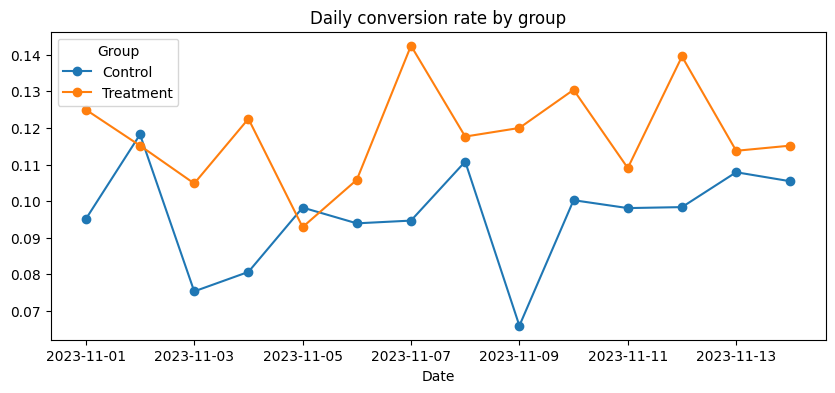

In [ ]:
import matplotlib.pyplot as plot

# assumes df is loaded, Date parsed to datetime, Group, Converted present
daily = df.groupby([df['Date'].dt.date, 'Group'])['Converted'].agg(['sum','count']).reset_index()
print(daily)
print()

# sum: This is the total number of conversions 
# count: This is the total number of users/observations (visitors) in that group on that date.

daily['conv_rate'] = daily['sum'] / daily['count'] # daily conversion rate for each group.
pivot = daily.pivot(index='Date', columns='Group', values='conv_rate')
# Its primary role is to transform data from a "long" format (many rows, few columns) into a "wide" format (fewer rows, many columns) by rotating or pivoting column values to become new column headers
print(pivot)   # inspect daily rates
# Optionally plot to visualize:
pivot.plot(marker='o', figsize=(10,4), title='Daily conversion rate by group')


In [7]:
# create a simple segment: high_clicks (>= median) vs low_clicks
df['click_segment'] = np.where(df['Clicks'] >= df['Clicks'].median(), 'high_clicks','low_clicks')
seg_summary = df.groupby(['click_segment','Group'])['Converted'].agg(['sum','count'])
seg_summary['conv_rate'] = seg_summary['sum'] / seg_summary['count']
print(seg_summary.unstack(level=1))


                  sum             count           conv_rate          
Group         Control Treatment Control Treatment   Control Treatment
click_segment                                                        
high_clicks       215       320    2339      2661  0.091920  0.120256
low_clicks        264       270    2661      2339  0.099211  0.115434


# Robustness & sanity check

Days Treatment > Control: 12 out of 14

TtestResult(statistic=12.215244578993143, pvalue=4.54964040589367e-34, df=9825.66026031598)


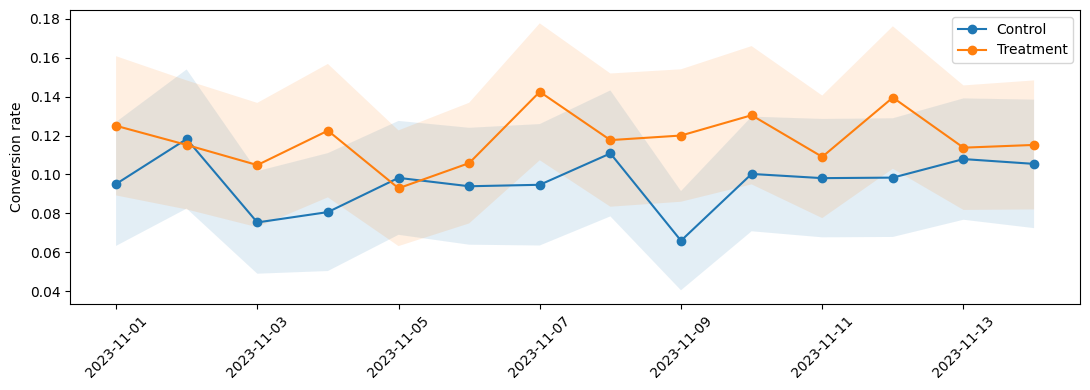

In [ ]:
import matplotlib.pyplot as plt
daily_pivot = daily.pivot(index='Date', columns='Group', values='sum').fillna(0)
daily_n = daily.pivot(index='Date', columns='Group', values='count').fillna(0)
conv_rate = (daily_pivot / daily_n)

# compute binomial CI (approx) for plotting:

import numpy as np
def ci_binomial(p,n,z=1.96): 
    se = np.sqrt(p*(1-p)/n); 
    return (p - z*se, p + z*se)

dates = conv_rate.index
ctrl = conv_rate['Control']
trt = conv_rate['Treatment']
ctrl_ci = [ci_binomial(ctrl.loc[d], int(daily_n.loc[d,'Control'])) for d in dates]
trt_ci = [ci_binomial(trt.loc[d], int(daily_n.loc[d,'Treatment'])) for d in dates]

plt.figure(figsize=(11,4))
plt.plot(dates, ctrl, marker='o', label='Control')
plt.plot(dates, trt, marker='o', label='Treatment')
plt.fill_between(dates, [c[0] for c in ctrl_ci], [c[1] for c in ctrl_ci], alpha=0.12)
plt.fill_between(dates, [c[0] for c in trt_ci], [c[1] for c in trt_ci], alpha=0.12)
plt.xticks(rotation=45); plt.ylabel('Conversion rate'); plt.legend(); plt.tight_layout()

comp = (conv_rate['Treatment'] > conv_rate['Control']).sum()
print(f"Days Treatment > Control: {comp} out of {len(conv_rate)}")
print()

from scipy.stats import ttest_ind, mannwhitneyu
ctrl_clicks = df[df['Group']=='Control']['Clicks']
trt_clicks  = df[df['Group']=='Treatment']['Clicks']
print(ttest_ind(trt_clicks, ctrl_clicks, equal_var=False))




# Power Analysis

### The code is performing a statistical power analysis for comparing two proportions (like success rates). In simple terms, it's about figuring out if you have a big enough sample size to detect a meaningful difference between two groups, and if your current sample size is adequate.

In [ ]:
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower

p1 = 479/5000
p2 = 590/5000

effect_size = proportion_effectsize(p2,p1) 
# tells us the magnitude of the difference between the new conversion rate and the old one
# A larger effect size means the new process is much better than the old one

x = power_analysis.solve_power(effect_size, power = 0.8, ratio= 1.0, alpha = 0.05)
print("Required n per group for 80% power", int(np.ceil(x)))
# If we want an 80% chance of correctly spotting this specific improvement (the effect_size), how many visitors do we need in each group?


# Statistical power is the probability that your test will correctly find a difference when one actually exists.
power_analysis = NormalIndPower()
power = power_analysis.power(effect_size, nobs1 = 5000, ratio = 1.0, alpha = 0.05)
print("Effect Size (Cohen`s h): ", effect_size)
print("Power: ", power)
print()

extra_conv_per_10000 = (p2-p1) * 10000
print("extra_conv_per_10000 is:", extra_conv_per_10000)
# Interpretation: For every 10,000 visitors using the new feature, the business can expect approximately 222 additional conversions compared to the old feature.

Required n per group for 80% power 3034
Effect Size (Cohen`s h):  0.07193882250897876
Power:  0.949182390735705

extra_conv_per_10000 is: 221.99999999999997
